# Classification of Machine Learning Models for Twitter Bot Classification

Date: October 15th, 2024

### Import required libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from lightgbm import LGBMClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.impute import KNNImputer
from sklearn.base import TransformerMixin
import string
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

### Exploratory Data Analysis (EDA)

In [ ]:
df = pd.read_csv('twitter_bot_dataset.csv')
df.head()

,followers_count,following_count,tweet_count,days_antiquity,description_length,username_digits,class
0,18.0,93.0,44.0,1969.0,11.0,0.0,0
1,34.0,719.0,1233.0,3961.0,NaN,2.0,0
2,27.0,173.0,7868.0,5038.0,NaN,0.0,0
3,385.0,660.0,52524.0,3961.0,110.0,0.0,0
4,230.0,749.0,28569.0,3960.0,NaN,3.0,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5541 entries, 0 to 5540
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   followers_count     5535 non-null   float64
 1   following_count     5535 non-null   float64
 2   tweet_count         5535 non-null   float64
 3   days_antiquity      5215 non-null   float64
 4   description_length  3299 non-null   float64
 5   username_digits     5539 non-null   float64
 6   class               5541 non-null   int64  
dtypes: float64(6), int64(1)
memory usage: 303.1 KB


In [4]:
df.describe()

,followers_count,following_count,tweet_count,days_antiquity,description_length,username_digits,class
count,5535.000000,5535.000000,5535.000000,5215.000000,3299.000000,5539.000000,5541.000000
mean,545.619874,479.669015,10059.481301,2248.794631,63.776296,2.129987,0.120556
std,9346.848178,2978.232074,32582.412265,1820.807936,47.294854,2.699277,0.325640
min,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000
25%,9.000000,48.000000,314.000000,468.500000,23.000000,0.000000,0.000000
50%,40.000000,153.000000,1590.000000,1986.000000,52.000000,1.000000,0.000000
75%,178.000000,456.000000,7398.500000,4120.500000,98.500000,4.000000,0.000000
max,614820.000000,212833.000000,952558.000000,6060.000000,175.000000,12.000000,1.000000


#### Evaluate Outliers

<ipython-input-5-6c340c7c4b8f>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='class', y=feature, data=df, palette={"0": "lightblue", "1": "salmon"})
<ipython-input-5-6c340c7c4b8f>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='class', y=feature, data=df, palette={"0": "lightblue", "1": "salmon"})
<ipython-input-5-6c340c7c4b8f>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='class', y=feature, data=df, palette={"0": "lightblue", "1": "salmon"})
<ipython-input-5-6c340c7c4b8f>:6: FutureWarning: 

Passing `palette` without assignin

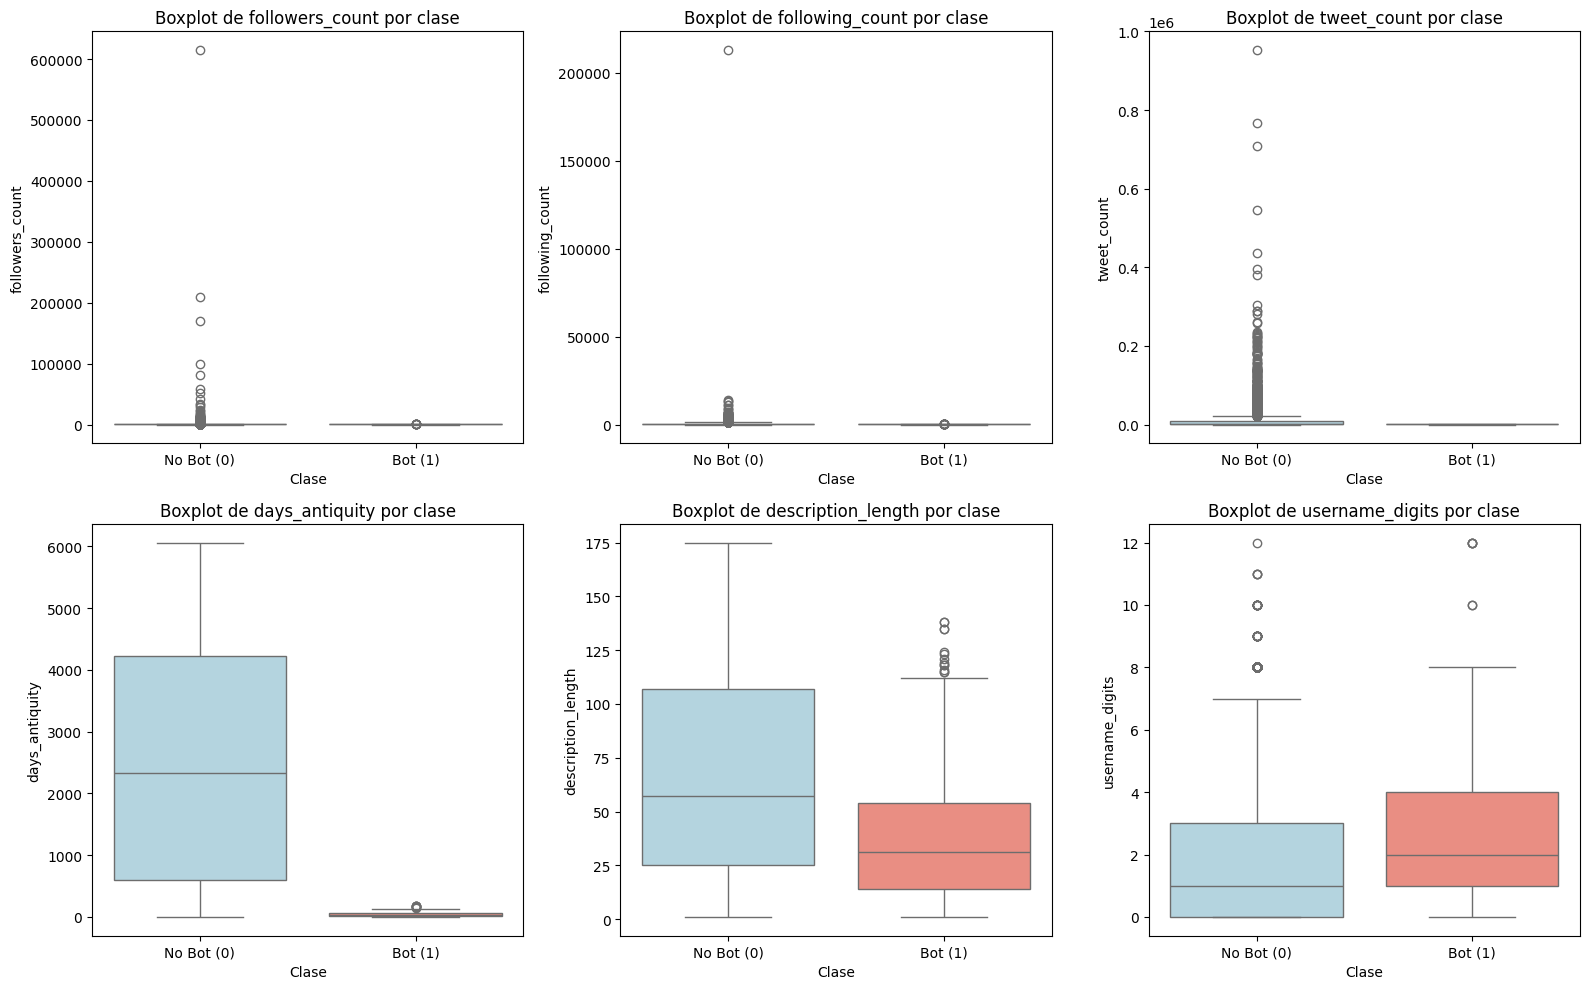

In [ ]:
features = ['followers_count', 'following_count', 'tweet_count', 'days_antiquity', 'description_length', 'username_digits']

plt.figure(figsize=(16, 10))
for i, feature in enumerate(features, 1):
    plt.subplot(2, 3, i)
    sns.boxplot(x='class', y=feature, data=df, palette={"0": "lightblue", "1": "salmon"})
    plt.title(f'Boxplot of {feature} by class')
    plt.xlabel('Clase')
    plt.ylabel(feature)
    plt.xticks(ticks=[0, 1], labels=['No Bot (0)', 'Bot (1)'])  # Etiquetas para las clases
    plt.tight_layout()
plt.show()


The boxplots show that most of the outliers correspond to 'no bot' accounts. Due to the nature of the study, it was decided not to eliminate the outliers since they may be characteristics of the accounts themselves. For example: a politician, a famous or renowned person, etc. Moreover, because we do not consider these values to be an error in the data, but simply a representation of user behavior.

#### Evaluate Missing Values

Missing Values: 
followers_count          6
following_count          6
tweet_count              6
days_antiquity         326
description_length    2242
username_digits          2
class                    0
dtype: int64


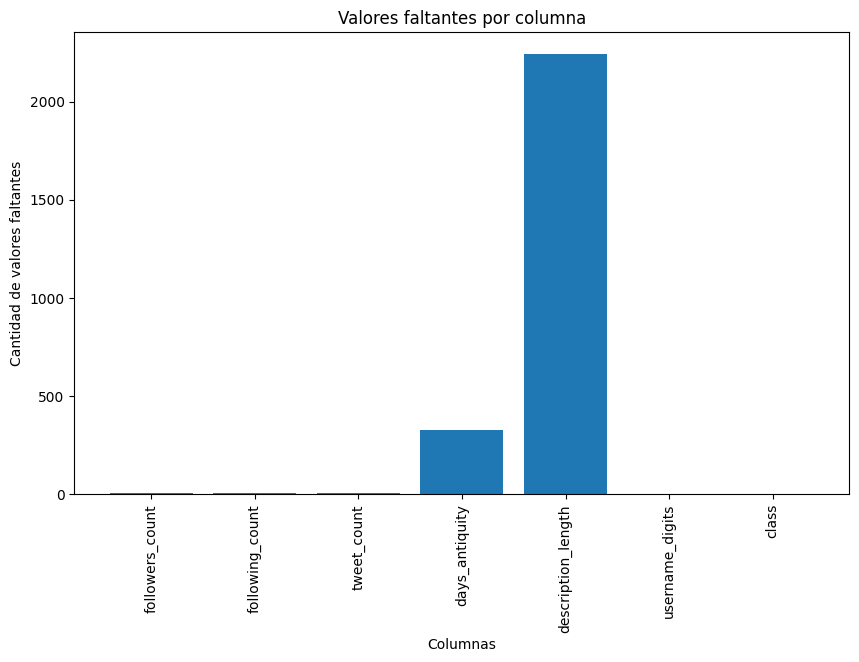

In [ ]:
missing_values = df.isnull().sum()
print(f'Missing Values: \n{missing_values}')

# Crea un gráfico de barras para visualizar los valores faltantes
plt.figure(figsize=(10, 6))
plt.bar(missing_values.index, missing_values.values)
plt.xticks(rotation=90)
plt.xlabel('Columns')
plt.ylabel('Number of missing values')
plt.title('Missing values per column')
plt.show()


There are a large number of missing values for the column days_antiquity and description_lenght. Therefore we will proceed to impute the missing values with the *KNNImputer* method which is based on replacing the missing values using the weighted average of the nearest neighbor values in terms of distance.

#### Evaluate Class Distribution

In [7]:
df.value_counts('class')

,count
class,
0,4873
1,668


There is a clear imbalance in the data, predominantly class 0 which is 'no bot'. Therefore, this could have an impact on the bias of the classifier as it does not have enough information to learn about the least representative class (bot).

#### Visualizations

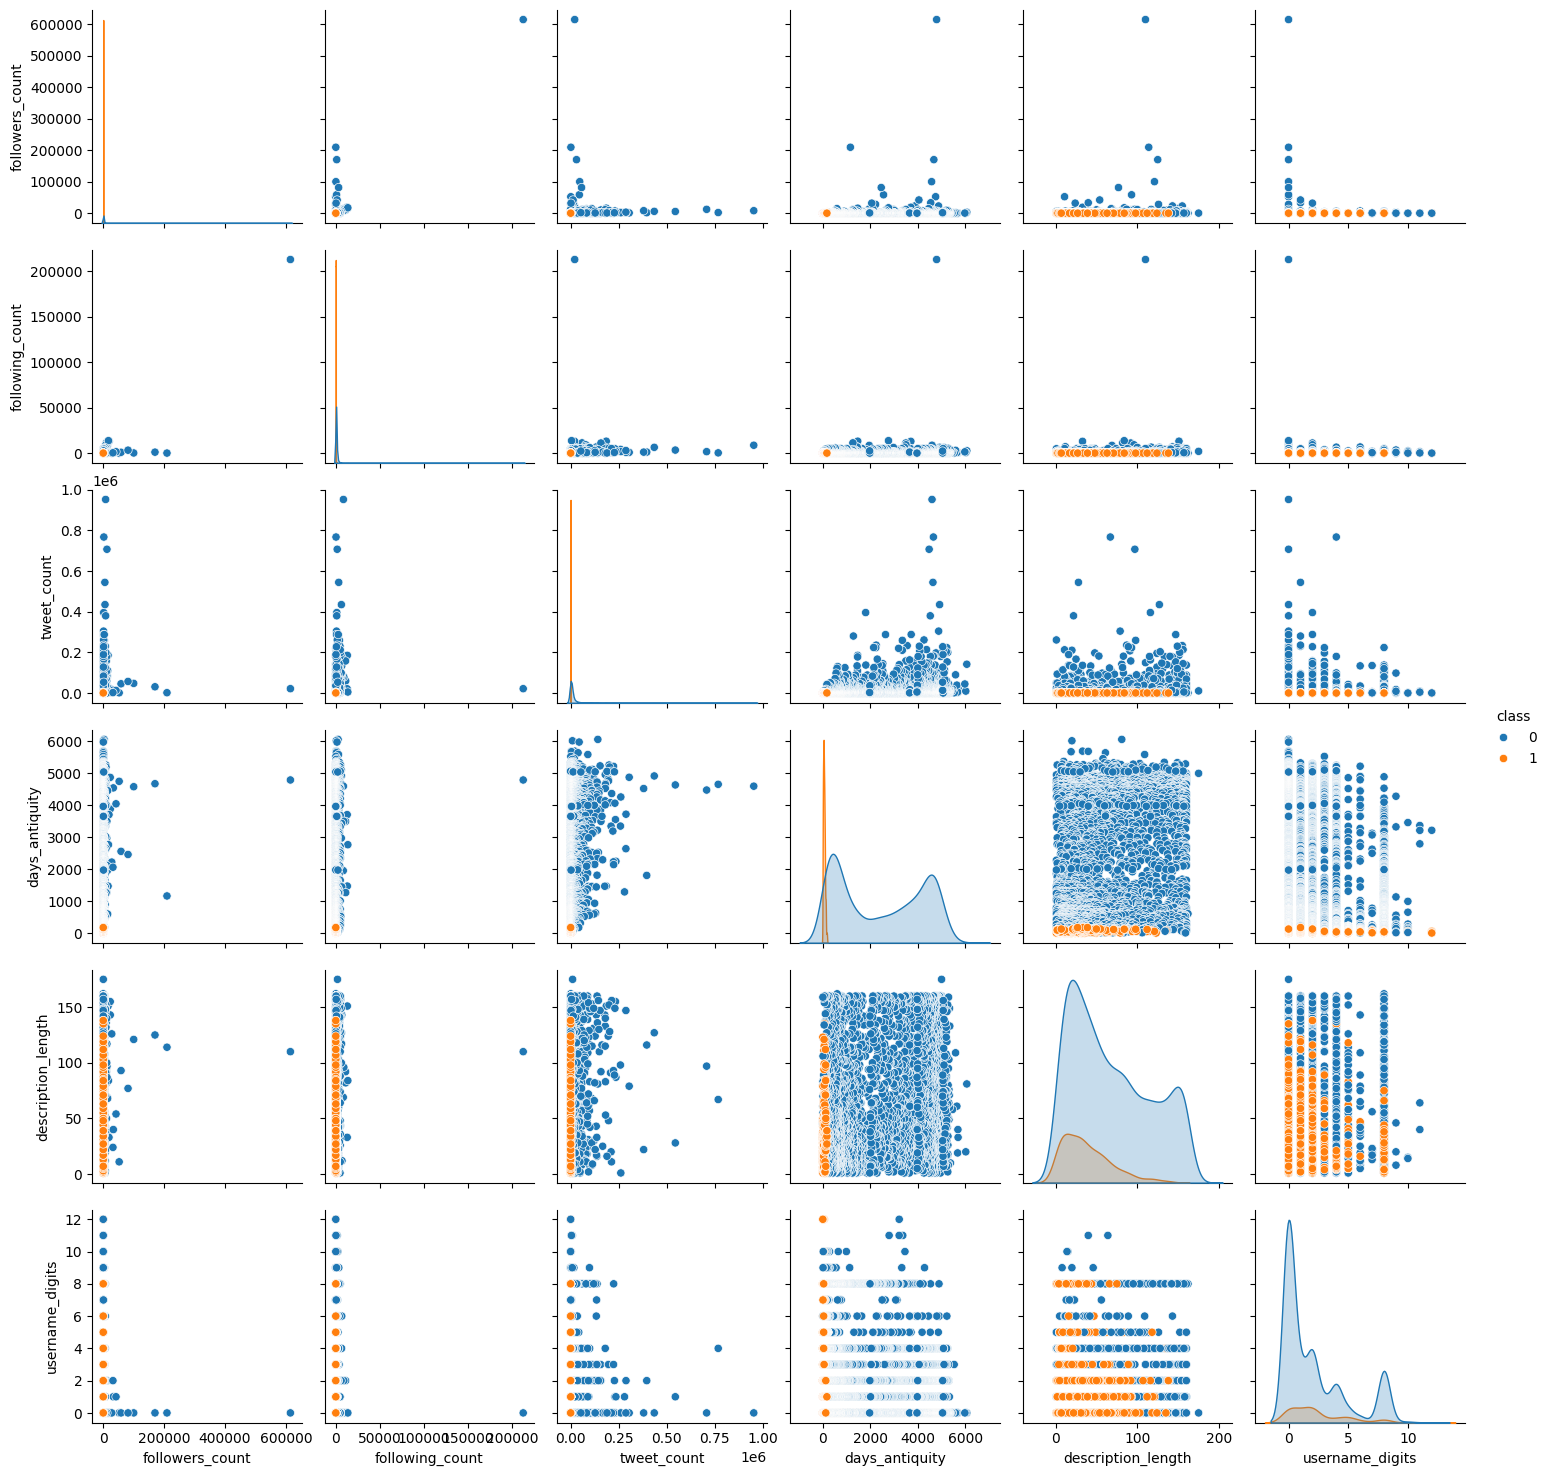

In [8]:
sns.pairplot(df, hue='class')

The pairs plot does not denote any relevant relationship between the variables in the dataset.

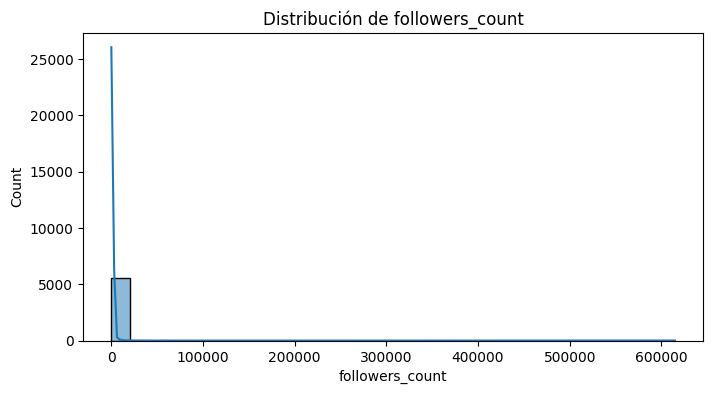

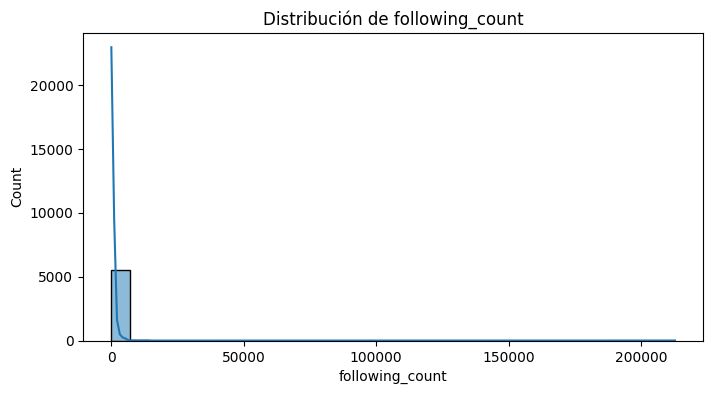

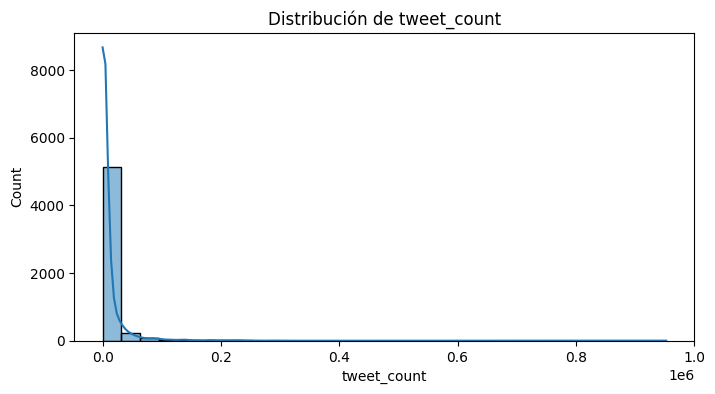

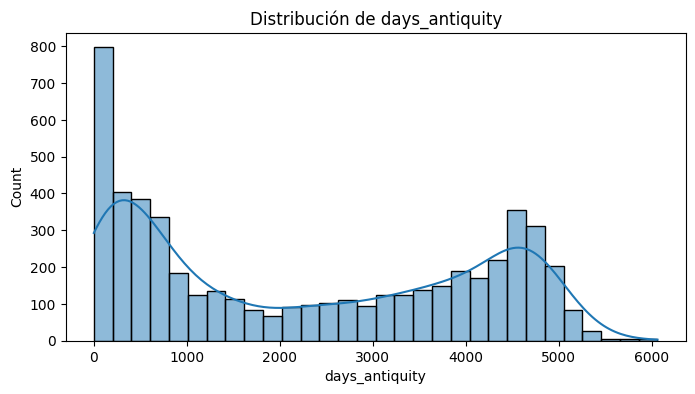

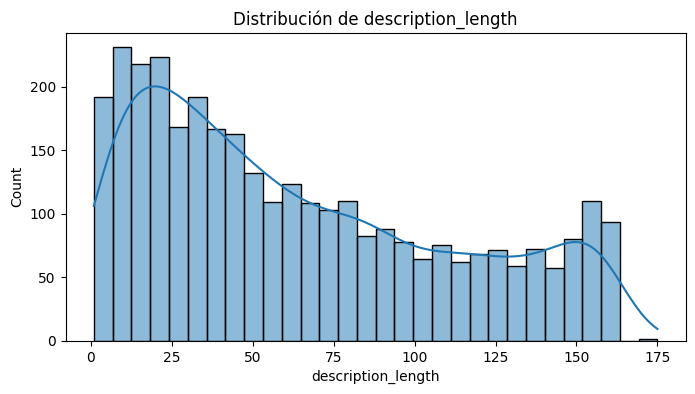

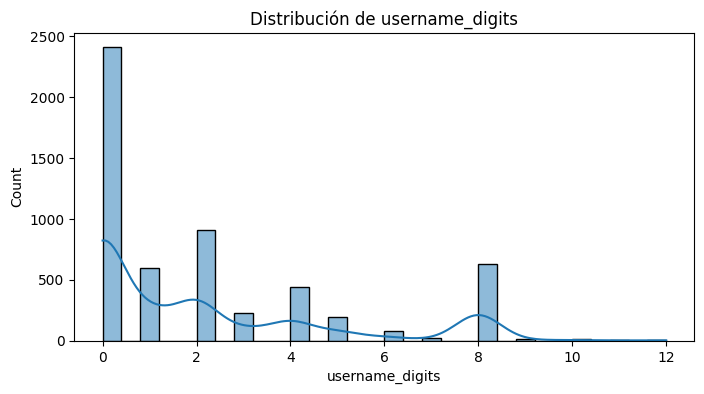

In [ ]:
# List of variables to be displayed
variables = ['followers_count', 'following_count', 'tweet_count', 'days_antiquity', 'description_length', 'username_digits']

# Create histograms
for var in variables:
    plt.figure(figsize=(8, 4))
    sns.histplot(df[var], kde=True, bins=30)
    plt.title(f'Distribución de {var}')
    plt.show()


###  Implementation of Classification Models

#### Define the independent variables, the dependent variable and split the dataset for train and test.

- Train: 80%
- Test: 20%

Relevant parameters:
- stratify = y: Returns training and test subsets that have the same proportions of class labels as the input data set.

In [10]:
X = df[['followers_count','following_count','tweet_count','days_antiquity','description_length', 'username_digits']]
y = df['class']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)
print(f'Train dataset: {X_train.shape}')
print(f'Test dataset:{X_test.shape}')

Train dataset: (4432, 6)
Test dataset:(1109, 6)


#### Decision Tree

In [ ]:
#Decision tree
param_grid_decision_tree = {
    'criterion': ['gini', 'entropy'], #measure the quality of a division
    'max_depth': [None, 10, 20, 30, 40], #defines the maximum depth of the tree
    'min_samples_split': [2, 10, 20], #minimum number of samples required to split a node
    'min_samples_leaf': [1, 5, 10], #minimum number of samples per sheet
    'max_features': [None, 'auto', 'sqrt', 'log2'], # maximum number of characteristics to be considered for the best division
    'ccp_alpha': [0.0, 0.01, 0.1] #complexity parameter for tree trimming
}

pipeline_decision_tree = Pipeline([
    ('imputer', KNNImputer(n_neighbors=5)), #Imputation of values
    ('scaler', StandardScaler()), #Value scaling / selected for less problems with outliers
    ('classifier',GridSearchCV(DecisionTreeClassifier(),param_grid_decision_tree,cv=10, scoring='recall'))
])


pipeline_decision_tree.fit(X_train,y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
2700 fits failed out of a total of 10800.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
2700 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1466, in wrapper
    estimator._validate_params()
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/

Pipeline(steps=[('imputer', KNNImputer()), ('scaler', StandardScaler()),
                ('classifier',
                 GridSearchCV(cv=10, estimator=DecisionTreeClassifier(),
                              param_grid={'ccp_alpha': [0.0, 0.01, 0.1],
                                          'criterion': ['gini', 'entropy'],
                                          'max_depth': [None, 10, 20, 30, 40],
                                          'max_features': [None, 'auto', 'sqrt',
                                                           'log2'],
                                          'min_samples_leaf': [1, 5, 10],
                                          'min_samples_split': [2, 10, 20]},
                              scoring='recall'))])

In [12]:
pipeline_decision_tree.named_steps['classifier'].best_params_

{'ccp_alpha': 0.0,
 'criterion': 'entropy',
 'max_depth': 10,
 'max_features': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2}

In [13]:
y_pred_decision_tree = pipeline_decision_tree.predict(X_test)

accuracy_tree_model = accuracy_score(y_test,y_pred_decision_tree)
print(f'Accuracy decision tree model: {accuracy_tree_model*100:.2f}')

Accuracy decision tree model: 95.13


In [14]:
print(f'Classification Report Decision Tree:')
print(classification_report(y_test,y_pred_decision_tree))

Classification Report Decision Tree:
              precision    recall  f1-score   support

           0       0.97      0.97      0.97       975
           1       0.81      0.78      0.80       134

    accuracy                           0.95      1109
   macro avg       0.89      0.88      0.88      1109
weighted avg       0.95      0.95      0.95      1109



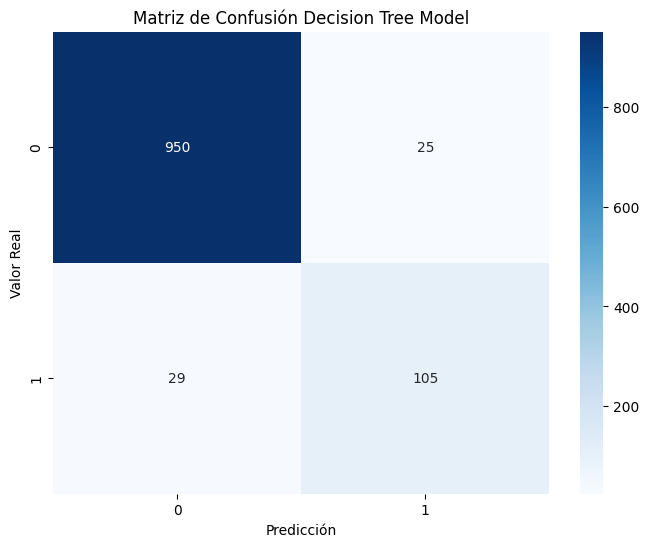

In [ ]:
plt.figure(figsize=(8.,6))
sns.heatmap(confusion_matrix(y_test,y_pred_decision_tree), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix Decision Tree Model')
plt.ylabel('Real Value')
plt.xlabel('Prediction')
plt.show()

#### Random Forest

In [17]:
#Random Forest
param_grid_random_forest = {
    'n_estimators': [100, 200],
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 10, 20],
    'min_samples_leaf': [1, 5, 10],
    'ccp_alpha': [0.0, 0.01]
}

pipeline_random_forest = Pipeline([
    ('imputer', KNNImputer(n_neighbors=5)),
    ('scaler', StandardScaler()),
    ('classifier',GridSearchCV(RandomForestClassifier(warm_start=True),param_grid_random_forest,cv=10, scoring='recall'))
])


pipeline_random_forest.fit(X_train,y_train)

Pipeline(steps=[('imputer', KNNImputer()), ('scaler', StandardScaler()),
                ('classifier',
                 GridSearchCV(cv=10,
                              estimator=RandomForestClassifier(warm_start=True),
                              param_grid={'ccp_alpha': [0.0, 0.01],
                                          'criterion': ['gini', 'entropy'],
                                          'max_depth': [None, 10, 20, 30],
                                          'min_samples_leaf': [1, 5, 10],
                                          'min_samples_split': [2, 10, 20],
                                          'n_estimators': [10, 20]},
                              scoring='recall'))])

In [18]:
pipeline_random_forest.named_steps['classifier'].best_params_

{'ccp_alpha': 0.0,
 'criterion': 'entropy',
 'max_depth': 30,
 'min_samples_leaf': 1,
 'min_samples_split': 10,
 'n_estimators': 10}

In [19]:
y_forest_predicted = pipeline_random_forest.predict(X_test)

accuracy_forest = accuracy_score(y_test,y_forest_predicted)
print(f'Accuracy random forest model: {accuracy_forest*100}')

Accuracy random forest model: 96.57348963029756


In [20]:
print(f'Classification Report Random Forest:')
print(classification_report(y_test,y_forest_predicted))

Classification Report Random Forest:
              precision    recall  f1-score   support

           0       0.98      0.99      0.98       975
           1       0.89      0.82      0.85       134

    accuracy                           0.97      1109
   macro avg       0.93      0.90      0.92      1109
weighted avg       0.96      0.97      0.97      1109



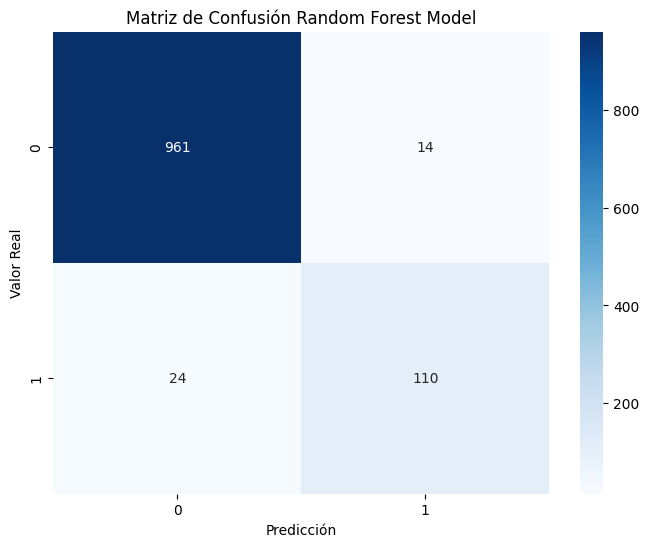

In [ ]:
plt.figure(figsize=(8.,6))
sns.heatmap(confusion_matrix(y_test,y_forest_predicted), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix Random Forest Model')
plt.ylabel('Real Value')
plt.xlabel('Prediction')
plt.show()

#### Support Vector Machines (SVM)

In [ ]:
#SVC
param_grid_svm = {
    'C': [0.1, 1, 10], #controls the penalty for classification errors
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid'], #kernel function to separate data
    'gamma': ['scale', 'auto'],
    'class_weight': [None, 'balanced'], #adjusts the weight of each class
    'shrinking': [True, False] #optimize training time
}

pipeline_svm = Pipeline([
    ('imputer', KNNImputer(n_neighbors=5)),
    ('scaler', StandardScaler()),
    ('classifier',GridSearchCV(SVC(), param_grid_svm,cv=10, scoring='recall'))
])


pipeline_svm.fit(X_train,y_train)

Pipeline(steps=[('imputer', KNNImputer()), ('scaler', StandardScaler()),
                ('classifier',
                 GridSearchCV(cv=10, estimator=SVC(),
                              param_grid={'C': [0.1, 1, 10],
                                          'class_weight': [None, 'balanced'],
                                          'gamma': ['scale', 'auto'],
                                          'kernel': ['linear', 'rbf', 'poly',
                                                     'sigmoid'],
                                          'shrinking': [True, False]},
                              scoring='recall'))])

In [23]:
pipeline_svm.named_steps['classifier'].best_params_

{'C': 1,
 'class_weight': 'balanced',
 'gamma': 'scale',
 'kernel': 'linear',
 'shrinking': True}

In [24]:
y_svm_predicted = pipeline_svm.predict(X_test)

accuracy_svm = accuracy_score(y_test,y_svm_predicted)
print(f'Accuracy SVM model: {accuracy_svm*100}')

Accuracy SVM model: 77.0063119927863


In [25]:
print(f'Classification SVM:')
print(classification_report(y_test,y_svm_predicted))

Classification SVM:
              precision    recall  f1-score   support

           0       0.99      0.74      0.85       975
           1       0.34      0.96      0.50       134

    accuracy                           0.77      1109
   macro avg       0.67      0.85      0.68      1109
weighted avg       0.91      0.77      0.81      1109



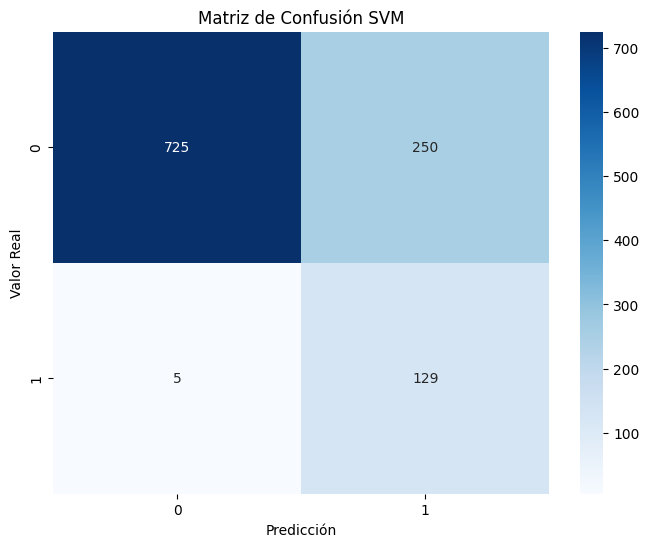

In [ ]:
plt.figure(figsize=(8.,6))
sns.heatmap(confusion_matrix(y_test,y_svm_predicted), annot=True, fmt='d', cmap='Blues')
plt.title('SVM Confusion Matrix')
plt.ylabel('Real Value')
plt.xlabel('Prediction')
plt.show()

#### LGBM

- Decision tree method.
- Used for classification and regression.
- Uses the concept of Gradient Boosting: builds trees sequentially. Each new tree adjusts to the errors of the previous set of trees.
- Uses histogram methods (bin clustering) for optimization and efficiency.
- Good for large volumes of data.

In [ ]:
param_grid_lgbm = {
    'n_estimators': [50, 100], #number of trees or iterations to be trained on the model
    'num_leaves': [31, 50], #maximum number of leaves allowed on a tree
    'max_depth': [-1, 10, 20], #maximum tree depth
    'learning_rate': [0.01, 0.1] #model learning rate
}

pipeline_lgbm = Pipeline([
    ('imputer', KNNImputer(n_neighbors=5)),
    ('scaler', StandardScaler()),
    ('classifier', GridSearchCV(LGBMClassifier(), param_grid_lgbm, cv=10, scoring='recall'))
])

pipeline_lgbm.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


[LightGBM] [Info] Number of positive: 480, number of negative: 3508
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001945 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1285
[LightGBM] [Info] Number of data points in the train set: 3988, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.120361 -> initscore=-1.989015
[LightGBM] [Info] Start training from score -1.989015
[LightGBM] [Info] Number of positive: 480, number of negative: 3508
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000452 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1285
[LightGBM] [Info] Number of data points in the train set: 3988, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.120361 -> initscore=-1.989015
[LightGBM] [

/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Pipeline(steps=[('imputer', KNNImputer()), ('scaler', StandardScaler()),
                ('classifier',
                 GridSearchCV(cv=10, estimator=LGBMClassifier(),
                              param_grid={'learning_rate': [0.01, 0.1],
                                          'max_depth': [-1, 10, 20],
                                          'n_estimators': [50, 100],
                                          'num_leaves': [31, 50]},
                              scoring='recall'))])

In [28]:
pipeline_lgbm.named_steps['classifier'].best_params_

{'learning_rate': 0.1, 'max_depth': -1, 'n_estimators': 100, 'num_leaves': 31}

In [ ]:
y_lgbm_predicted = pipeline_lgbm.predict(X_test)

accuracy_lgbm = accuracy_score(y_test,y_lgbm_predicted)
print(f'Accuracy LGBM model: {accuracy_lgbm*100}')

Accuracy QDA model: 96.9341749323715


In [30]:
print(f'Classification LGBM:')
print(classification_report(y_test,y_lgbm_predicted))

Classification LGBM:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       975
           1       0.88      0.87      0.87       134

    accuracy                           0.97      1109
   macro avg       0.93      0.92      0.93      1109
weighted avg       0.97      0.97      0.97      1109



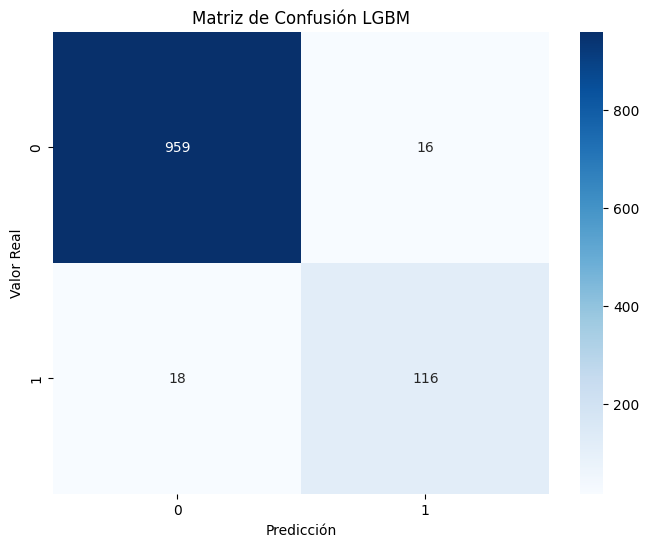

In [31]:
plt.figure(figsize=(8.,6))
sns.heatmap(confusion_matrix(y_test,y_lgbm_predicted), annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusión LGBM')
plt.ylabel('Valor Real')
plt.xlabel('Predicción')
plt.show()

### Model Comparison

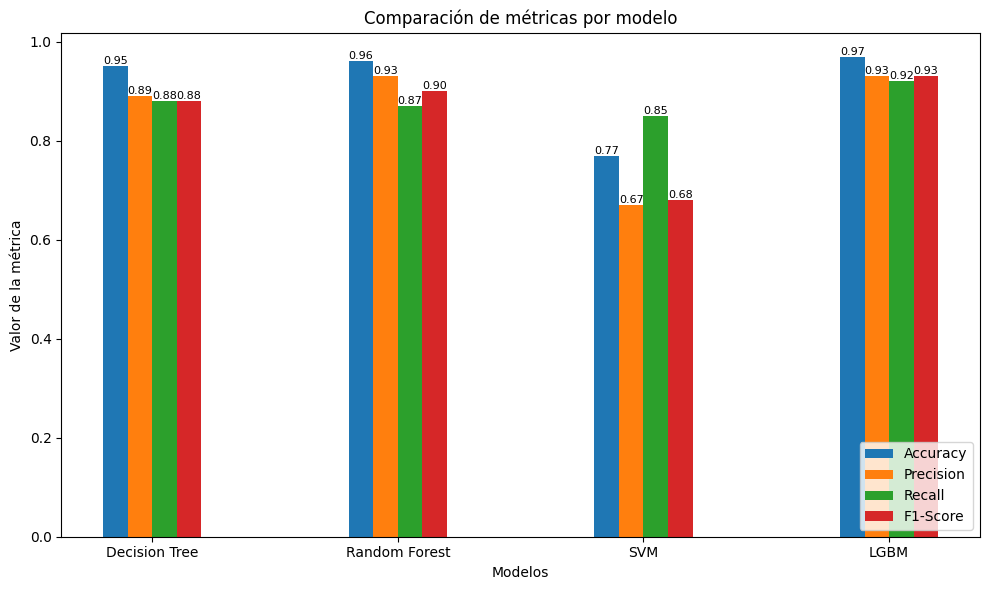

In [ ]:
models = ['Decision Tree', 'Random Forest', 'SVM', 'LGBM']
accuracy = [0.95, 0.96, 0.77, 0.9693]
precision = [0.89, 0.93, 0.67, 0.93]
recall = [0.88, 0.87, 0.85, 0.92]
f1_score = [0.88, 0.90, 0.68, 0.93]

x = np.arange(len(models))
width = 0.1

fig, ax = plt.subplots(figsize=(10, 6))
bars_accuracy = ax.bar(x - width * 1.5, accuracy, width, label='Accuracy')
bars_precision = ax.bar(x - width / 2, precision, width, label='Precision')
bars_recall = ax.bar(x + width / 2, recall, width, label='Recall')
bars_f1_score = ax.bar(x + width * 1.5, f1_score, width, label='F1-Score')

for bars in [bars_accuracy, bars_precision, bars_recall, bars_f1_score]:
    for bar in bars:
        yval = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, yval, f'{yval:.2f}', ha='center', va='bottom', fontsize=8)

# Añadir etiquetas y título
ax.set_xlabel('Models')
ax.set_ylabel('Values')
ax.set_title('Comparison of metrics by model')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend(loc='lower right')
plt.tight_layout()
plt.show()


We can draw several conclusions from our metrics graph:

- Accuracy: This metric although it can be an indicator about the overall performance of our model, many times it can be biased by an unbalance of the classes. In our case, our dataset is quite unbalanced.

- Recall: This metric tells us how many positive values are correctly classified. In our case, we are interested in identifying as many bots as possible, so this metric helps us to evaluate the behavior of the model according to this need. However, it is important to view the individual metric in conjunction with the other metrics to have a complete understanding. For example, in the SVM we see high recall, but poor values for the other metrics.

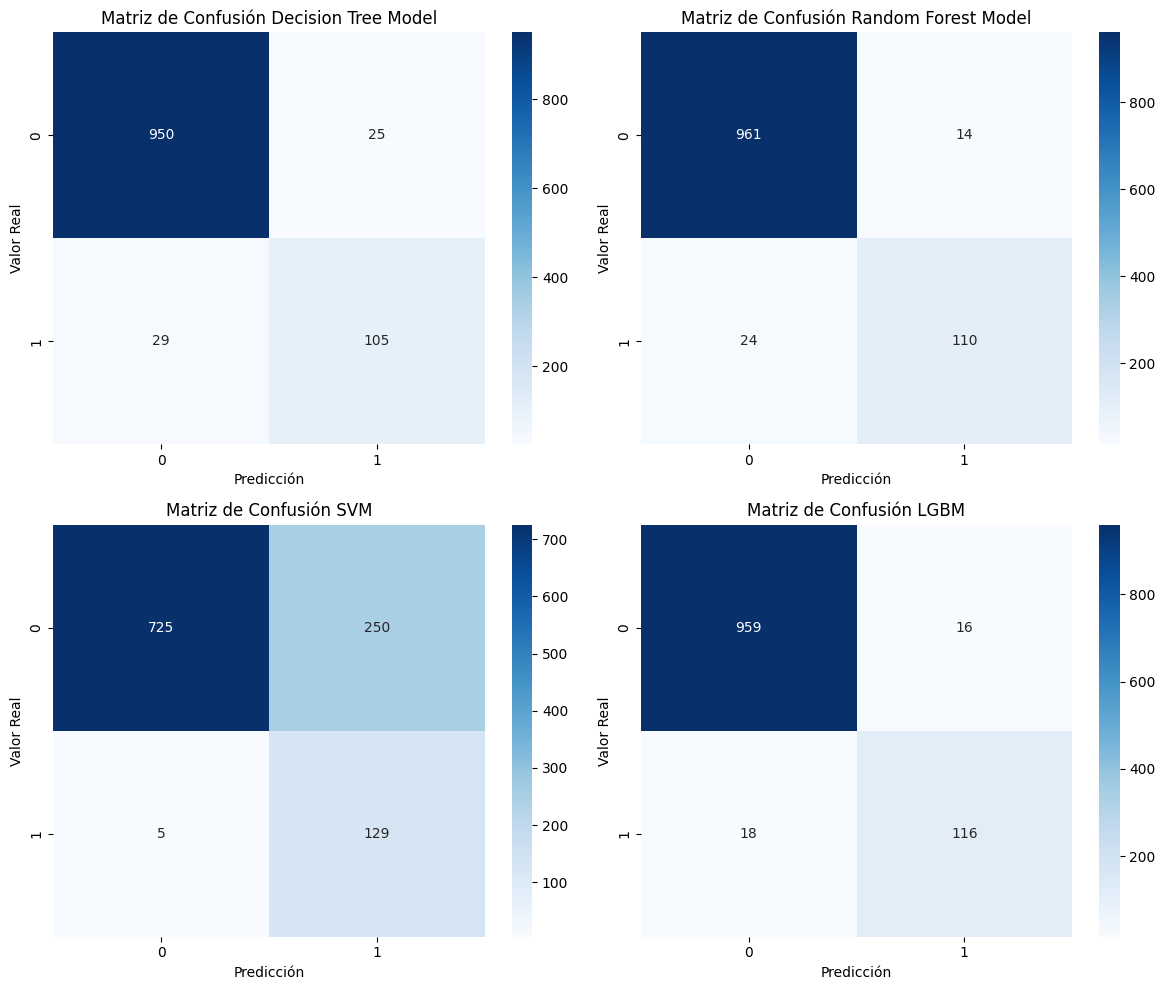

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

#Decision Tree
sns.heatmap(confusion_matrix(y_test, y_pred_decision_tree), annot=True, fmt='d', cmap='Blues', ax=axes[0, 0])
axes[0, 0].set_title('Confusion Matrix Decision Tree Model')
axes[0, 0].set_ylabel('Real Value')
axes[0, 0].set_xlabel('Prediction')

#Random Forest
sns.heatmap(confusion_matrix(y_test, y_forest_predicted), annot=True, fmt='d', cmap='Blues', ax=axes[0, 1])
axes[0, 1].set_title('Confusion Matrix Random Forest Model')
axes[0, 1].set_ylabel('Real Value')
axes[0, 1].set_xlabel('Prediction')

# SVM
sns.heatmap(confusion_matrix(y_test, y_svm_predicted), annot=True, fmt='d', cmap='Blues', ax=axes[1, 0])
axes[1, 0].set_title('SVM Confusion Matrix')
axes[1, 0].set_ylabel('Real Value')
axes[1, 0].set_xlabel('Prediction')

#LGBM
sns.heatmap(confusion_matrix(y_test, y_lgbm_predicted), annot=True, fmt='d', cmap='Blues', ax=axes[1, 1])
axes[1, 1].set_title('LGBM Confusion Matrix')
axes[1, 1].set_ylabel('Real Value')
axes[1, 1].set_xlabel('Prediction')
plt.tight_layout()
plt.show()


 
It is important to evaluate the overall proportion of the classified values. It is not only valid to focus on the correctly classified bots, but to look at the proportion of the rest of the dataset.


## Conclusions of the models:
- Numerical Features: Algorithms such as Decision Tree and Random Forest are good at handling numerical features.
- Unbalanced Classes: Random Forest and Decision Tree have some ability to handle imbalance, models like SVM and Naive Bayes can result in very poor performance if they are not properly tuned for that imbalance.
- LGBMClassifier: Being a boosting model, it has the ability to learn from the errors of previous models, allowing for greater accuracy in handling complexity and nonlinearities in the data. Random Forest and LGBMClassifier are less prone to this due to their ensemble mechanism.